In [1]:
import pandas as pd
import numpy as np
grid = pd.read_pickle("outputs_in_instab_strip.pkl")

# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

size = X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)
Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])
torch.Size([122651, 30, 2])


In [ ]:
import torch
import matplotlib.pyplot as plt
import pickle

# --- Reload model and corrections ---
from P7dsfmeanpdnu.py import SegmentationPointNet, DeltaNuCorrection  # adapt import path

# Reload training data info
grid = pd.read_pickle("outputs_in_instab_strip.pkl")
n_stars = len(grid)
delta_nu_hard = torch.tensor(grid["delta_nu"].values[:n_stars], dtype=torch.float32)

# Load model with weights
model = SegmentationPointNet(
    n_stars=n_stars,
    delta_nu_hard=delta_nu_hard,
    num_classes=4
)
model.load_state_dict(torch.load("segmentation_pointnet_dsfmeanpdnu.pth", map_location="cpu"))
model.eval()

# Extract corrections
delta_nu_corr = model.delta_nu_module.delta_nu_corr.detach().cpu().numpy()
delta_nu_hard = model.delta_nu_module.delta_nu_hard.detach().cpu().numpy()
delta_nu_final = delta_nu_hard + delta_nu_corr

# --- Plot absolute corrections ---
plt.figure(figsize=(8,5))
plt.hist(delta_nu_corr, bins=30, alpha=0.7, color="royalblue")
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Δν correction [µHz?]")
plt.ylabel("Number of stars")
plt.title("Distribution of learned Δν corrections")
plt.show()

# --- Plot original vs corrected ---
plt.figure(figsize=(6,6))
plt.scatter(delta_nu_hard, delta_nu_final, s=15, alpha=0.7)
plt.plot([delta_nu_hard.min(), delta_nu_hard.max()],
         [delta_nu_hard.min(), delta_nu_hard.max()],
         "r--", label="No correction")
plt.xlabel("Original Δν (hard prior)")
plt.ylabel("Corrected Δν (hard+learned)")
plt.title("Δν corrections per star")
plt.legend()
plt.show()

# --- Plot relative corrections ---
rel_corr = delta_nu_corr / delta_nu_hard
plt.figure(figsize=(8,5))
plt.hist(rel_corr, bins=30, alpha=0.7, color="seagreen")
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Relative correction Δν_corr / Δν_hard")
plt.ylabel("Number of stars")
plt.title("Relative Δν corrections")
plt.show()


Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])
Epoch   0: Train Loss = 1.0643, Test Loss = 1.2573, Train Acc = 0.3079, Test Acc = 0.3651
Epoch   1: Train Loss = 1.0813, Test Loss = 1.2492, Train Acc = 0.3095, Test Acc = 0.3685
Epoch   2: Train Loss = 1.0496, Test Loss = 1.2440, Train Acc = 0.3103, Test Acc = 0.3683
Epoch   3: Train Loss = 1.0458, Test Loss = 1.2418, Train Acc = 0.3102, Test Acc = 0.3737
Epoch   4: Train Loss = 1.0445, Test Loss = 1.2379, Train Acc = 0.3132, Test Acc = 0.3802
Epoch   5: Train Loss = 1.0431, Test Loss = 1.2413, Train Acc = 0.3144, Test Acc = 0.3803
Epoch   6: Train Loss = 1.0660, Test Loss = 1.2412, Train Acc = 0.3198, Test Acc = 0.3786
Epoch   7: Train Loss = 1.0688, Test Loss = 1.2333, Train Acc = 0.3242, Test Acc = 0.3795
Epoch   8: Train Loss = 1.0305, Test Loss = 1.2345, Train Acc = 0.3216, Test Acc = 0.3835
Epoch   9: Train Loss = 1.0351, Test Loss = 1.2341, Train Acc = 0.3323, Test Acc 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Define only the classes needed ---
class DeltaNuCorrection(nn.Module):
    def __init__(self, n_stars, delta_nu_hard):
        super().__init__()
        self.register_buffer("delta_nu_hard", delta_nu_hard.clone())
        self.delta_nu_corr = nn.Parameter(torch.zeros_like(delta_nu_hard))
        self.eps = 1e-3

    def forward(self, frequencies, star_indices):
        delta = (self.delta_nu_hard[star_indices] + self.delta_nu_corr[star_indices]).clamp_min(self.eps)
        delta = delta.unsqueeze(1)
        return frequencies % delta

class PointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, aggregator="mean"):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=1)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)
        self.aggregator = aggregator

    def forward(self, x, mask=None):
        B, N, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))
        if self.aggregator == "max":
            if mask is not None:
                m = (mask.unsqueeze(1) > 0).float()
                x = x.masked_fill(m == 0, -1e9)
            x = x.amax(dim=-1, keepdim=True)
        elif self.aggregator == "mean":
            if mask is None:
                x = x.mean(dim=-1, keepdim=True)
            else:
                m = (mask.unsqueeze(1) > 0).float()
                x = (x * m).sum(dim=-1, keepdim=True) / m.sum(dim=-1, keepdim=True).clamp_min(1.0)
        else:
            raise ValueError(f"Unknown aggregator: {self.aggregator}")
        return x.view(B, -1)

class SegmentationPointNet(nn.Module):
    def __init__(self, n_stars, delta_nu_hard, num_classes=4, point_dimension=2, aggregator="mean"):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension, aggregator=aggregator)
        nhidden = 64
        nfeat = 64
        self.fc_1 = nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = nn.Linear(nhidden, num_classes)
        self.delta_nu_module = DeltaNuCorrection(n_stars, delta_nu_hard)

    def forward(self, x, star_indices, mask=None):
        freq = x[:, :, 0]
        modf = self.delta_nu_module(freq, star_indices)
        x2 = torch.stack((freq, modf), dim=2)
        g = self.base_pointnet(x2, mask=mask)
        g = g.unsqueeze(1).expand(-1, x2.shape[1], -1)
        z = torch.cat([x2, g], dim=2)
        z = F.relu(self.fc_1(z))
        return F.log_softmax(self.fc_2(z), dim=2)

# --- Load data for Δν baseline ---
grid = pd.read_pickle("outputs_in_instab_strip.pkl")
delta_nu_hard = torch.tensor(grid["delta_nu"].values, dtype=torch.float32)

# --- Reload full model with saved weights ---
model = SegmentationPointNet(n_stars=len(delta_nu_hard), delta_nu_hard=delta_nu_hard)
state_dict = torch.load("segmentation_pointnet_dsfmeanpdnu.pth", map_location="cpu")
model.load_state_dict(state_dict)

# --- Extract Δν corrections ---
with torch.no_grad():
    dnu_hard = model.delta_nu_module.delta_nu_hard.cpu().numpy()
    dnu_corr = model.delta_nu_module.delta_nu_corr.cpu().numpy()
    dnu_corrected = dnu_hard + dnu_corr

# --- Plot histogram of corrections ---
plt.figure(figsize=(6,4), dpi=120)
plt.hist(dnu_corr, bins=40, color="cornflowerblue", alpha=0.8)
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Δν correction [µHz]")
plt.ylabel("Number of stars")
plt.title("Histogram of Δν corrections (dsfmeanpdnu model)")
plt.tight_layout()
plt.show()

# --- Scatterplot: original vs corrected ---
plt.figure(figsize=(5,5), dpi=120)
plt.scatter(dnu_hard, dnu_corrected, alpha=0.6, color="seagreen", edgecolor="k", s=40)
lims = [min(dnu_hard.min(), dnu_corrected.min()), max(dnu_hard.max(), dnu_corrected.max())]
plt.plot(lims, lims, "k--", label="No correction")
plt.xlabel("Original Δν [µHz]")
plt.ylabel("Corrected Δν [µHz]")
plt.title("Original vs Corrected Δν per star")
plt.legend()
plt.tight_layout()
plt.show()


RuntimeError: Error(s) in loading state_dict for SegmentationPointNet:
	size mismatch for delta_nu_module.delta_nu_corr: copying a param with shape torch.Size([122651]) from checkpoint, the shape in current model is torch.Size([153314]).
	size mismatch for delta_nu_module.delta_nu_hard: copying a param with shape torch.Size([122651]) from checkpoint, the shape in current model is torch.Size([153314]).

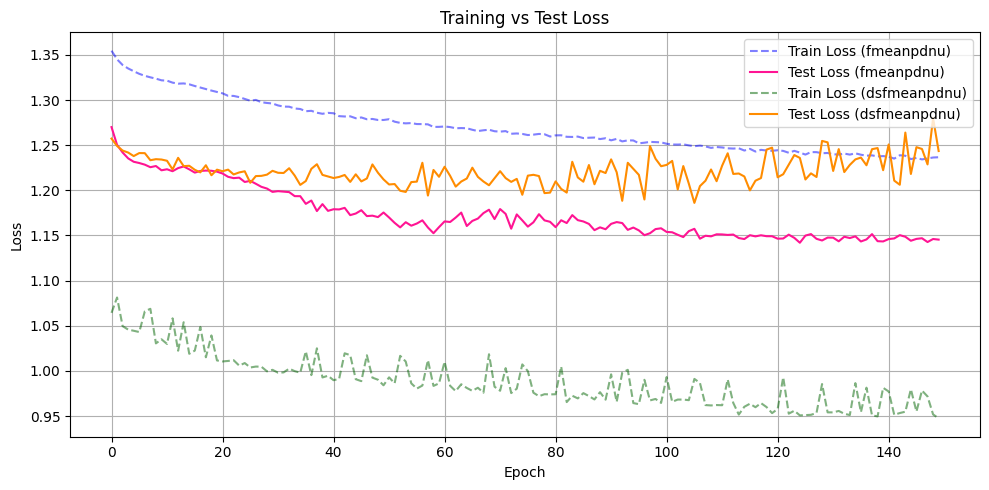

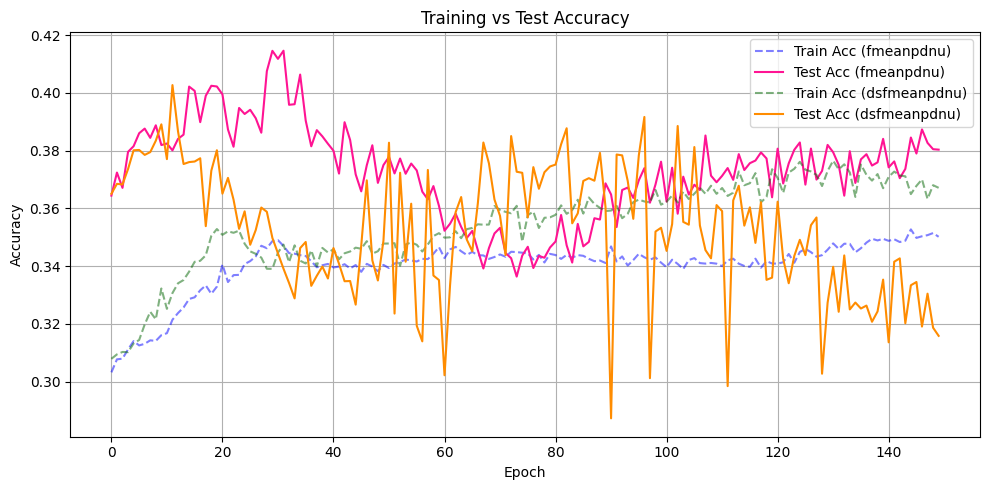

Final Test Accuracy (fmeanpdnu): 0.37872858509435603
Final Test Accuracy (dsfmeanpdnu): 0.31587529350378296


In [2]:
import pickle
import matplotlib.pyplot as plt

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

train_loss_fmeanpdnu = load_pickle("train_history_fmeanpdnu.pkl")
test_loss_fmeanpdnu  = load_pickle("test_history_fmeanpdnu.pkl")
train_loss_dsfmeanpdnu = load_pickle("train_history_dsfmeanpdnu.pkl")
test_loss_dsfmeanpdnu  = load_pickle("test_history_dsfmeanpdnu.pkl")
train_acc_fmeanpdnu = load_pickle("train_acc_history_fmeanpdnu.pkl")
test_acc_fmeanpdnu  = load_pickle("test_acc_history_fmeanpdnu.pkl")
train_acc_dsfmeanpdnu = load_pickle("train_acc_history_dsfmeanpdnu.pkl")
test_acc_dsfmeanpdnu  = load_pickle("test_acc_history_dsfmeanpdnu.pkl")
test_accuracy_fmeanpdnu  = load_pickle("test_accuracy_fmeanpdnu.pkl")
test_accuracy_dsfmeanpdnu = load_pickle("test_accuracy_dsfmeanpdnu.pkl")

plt.figure(figsize=(10, 5))
plt.plot(train_loss_fmeanpdnu, label="Train Loss (fmeanpdnu)", color="blue", linestyle="--", alpha=0.5)
plt.plot(test_loss_fmeanpdnu,  label="Test Loss (fmeanpdnu)", color="deeppink")
plt.plot(train_loss_dsfmeanpdnu, label="Train Loss (dsfmeanpdnu)", color="darkgreen", linestyle="--", alpha=0.5)
plt.plot(test_loss_dsfmeanpdnu,  label="Test Loss (dsfmeanpdnu)", color="darkorange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curves_dsfmeanpdnu.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_fmeanpdnu, label="Train Acc (fmeanpdnu)", color="blue", linestyle="--", alpha=0.5)
plt.plot(test_acc_fmeanpdnu,  label="Test Acc (fmeanpdnu)", color="deeppink")
plt.plot(train_acc_dsfmeanpdnu, label="Train Acc (dsfmeanpdnu)", color="darkgreen", linestyle="--", alpha=0.5)
plt.plot(test_acc_dsfmeanpdnu,  label="Test Acc (dsfmeanpdnu)", color="darkorange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_curves_dsfmeanpdnu.png", dpi=300)
plt.show()

# summary
print("Final Test Accuracy (fmeanpdnu):", test_accuracy_fmeanpdnu)
print("Final Test Accuracy (dsfmeanpdnu):", test_accuracy_dsfmeanpdnu)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import torch

# Config
REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 'fake'
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

num_models = X_test.shape[0]
num_points = X_test.shape[1]

# Pick a random model/sample
model_idx = random.randint(0, num_models - 1)
print(f"Selected model index: {model_idx}")

def prepare_plot_data(output_logits, y_test):
    # logits: [num_classes, num_points] tensor
    logits = output_logits[model_idx].detach().cpu().numpy() if torch.is_tensor(output_logits) else output_logits[model_idx]
    labels = y_test[model_idx]

    # Extract frequency mod Δν and power from X_test
    freqs = X_test[model_idx,:,1].numpy() if torch.is_tensor(X_test) else X_test[model_idx,:,1]
    powers = X_test[model_idx,:,0].numpy() if torch.is_tensor(X_test) else X_test[model_idx,:,0]

    # Mask invalid points
    valid_mask = labels != -1
    labels = labels[valid_mask]
    logits = logits[:, valid_mask]  # keep all classes
    freqs = freqs[valid_mask]
    powers = powers[valid_mask]

    # Convert logits to probabilities
    logits = logits - np.max(logits, axis=0, keepdims=True)
    probs = np.exp(logits)
    probs /= probs.sum(axis=0, keepdims=True)

    # Predictions
    preds = np.argmax(probs, axis=0)
    preds_display = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)
    labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)

    probs_true_label = np.array([probs[l,i] if l in REAL_CLASSES else 0.0 for i,l in enumerate(labels)])
    colors_true = [color_map[l] for l in labels_display]
    edge_colors_pred = [color_map[p] for p in preds_display]

    # Misclassified points
    wrong_mask = preds != labels
    wrong_freqs = freqs[wrong_mask]
    wrong_powers = powers[wrong_mask]
    wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

    return freqs, powers, labels_display, preds_display, probs_true_label, colors_true, wrong_freqs, wrong_powers, wrong_edge_colors

# Prepare data for fmeanp and dsfmeanp
f_freqs, f_powers, f_labels_disp, f_preds_disp, f_probs_true, f_colors, f_wrong_freqs, f_wrong_powers, f_wrong_edges = prepare_plot_data(output_fmeanp, y_test_fmeanp)
d_freqs, d_powers, d_labels_disp, d_preds_disp, d_probs_true, d_colors, d_wrong_freqs, d_wrong_powers, d_wrong_edges = prepare_plot_data(output_dsfmeanp, y_test_dsfmeanp)

# Plot 2x2
fig, axs = plt.subplots(2,2, figsize=(14,12), dpi=300)

# Top row: Fmeanp
axs[0,0].scatter(f_freqs, f_powers, c=f_colors, edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,0].set_title("Fmeanp — True Mode Labels")
axs[0,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,0].set_ylabel("Frequency (d$^{-1}$)")

axs[0,1].scatter(f_freqs, f_powers, c=f_colors, alpha=np.clip(f_probs_true,0.3,1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,1].scatter(f_wrong_freqs, f_wrong_powers, facecolors='none', edgecolors=f_wrong_edges, linewidths=2.0, s=marker_size+80)
for i in range(len(f_freqs)):
    axs[0,1].text(f_freqs[i], f_powers[i]+0.8, f"{f_probs_true[i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[0,1].set_title("Fmeanp — Model Predictions")
axs[0,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,1].set_ylabel("Frequency (d$^{-1}$)")

# Bottom row: DSFmeanp
axs[1,0].scatter(d_freqs, d_powers, c=d_colors, edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,0].set_title("DSFmeanp — True Mode Labels")
axs[1,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,0].set_ylabel("Frequency (d$^{-1}$)")

axs[1,1].scatter(d_freqs, d_powers, c=d_colors, alpha=np.clip(d_probs_true,0.3,1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,1].scatter(d_wrong_freqs, d_wrong_powers, facecolors='none', edgecolors=d_wrong_edges, linewidths=2.0, s=marker_size+80)
for i in range(len(d_freqs)):
    axs[1,1].text(d_freqs[i], d_powers[i]+0.8, f"{d_probs_true[i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[1,1].set_title("DSFmeanp — Model Predictions")
axs[1,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,1].set_ylabel("Frequency (d$^{-1}$)")

# Legend
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l=0'),
    mpatches.Patch(color=color_map[1], label='l=1'),
    mpatches.Patch(color=color_map[2], label='l=2'),
    mpatches.Patch(color=color_map[FAKE_CLASS], label='fake')
]
axs[0,0].legend(handles=legend_elements, title="l-mode", loc="upper right")
axs[1,0].legend(handles=legend_elements, title="l-mode", loc="upper right")

plt.tight_layout()
plt.show()

Selected model index: 7796


NameError: name 'output_fmeanp' is not defined

## Maybe also plot the fake frequencies that were injected? 
# doesn not work bc we didn't store fale freqs but still keeping this here

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

# Config
REAL_CLASSES = [0, 1, 2]
FAKE_CLASS = 3  # matches your training
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', FAKE_CLASS: 'gold'}
marker_size = 70

# Pick a random model/sample
num_models = X_test.shape[0]
model_idx = np.random.randint(0, num_models)
print(f"Selected model index: {model_idx}")

def prepare_plot_data(output_logits, y_test, X_test):
    # Extract logits and labels for selected model
    logits = output_logits[model_idx].detach().cpu().numpy() if torch.is_tensor(output_logits) else output_logits[model_idx]
    labels = y_test[model_idx]
    
    # Get frequencies
    freqs = X_test[model_idx, :, 0].numpy() if torch.is_tensor(X_test) else X_test[model_idx, :, 0]
    mod_nu = X_test[model_idx, :, 1].numpy() if torch.is_tensor(X_test) else X_test[model_idx, :, 1]

    # Mask valid points
    valid_mask = labels != -1
    labels = labels[valid_mask]
    logits = logits[:, valid_mask]
    freqs = freqs[valid_mask]
    mod_nu = mod_nu[valid_mask]

    # Probabilities
    logits = logits - np.max(logits, axis=0, keepdims=True)
    probs = np.exp(logits)
    probs /= probs.sum(axis=0, keepdims=True)

    # Predictions
    preds = np.argmax(probs, axis=0)
    
    # Display labels
    labels_display = np.array([l if l in REAL_CLASSES else FAKE_CLASS for l in labels], dtype=object)
    preds_display  = np.array([p if p in REAL_CLASSES else FAKE_CLASS for p in preds], dtype=object)
    
    # Probabilities of true labels (for alpha)
    probs_true_label = np.array([probs[l,i] if l in REAL_CLASSES else 1.0 for i,l in enumerate(labels)])

    # Colors
    colors_true = [color_map[l] for l in labels_display]
    edge_colors_pred = [color_map[p] for p in preds_display]

    # Misclassified points (excluding fake points)
    wrong_mask = (preds != labels) & (labels != FAKE_CLASS)
    wrong_freqs = freqs[wrong_mask]
    wrong_mod_nu = mod_nu[wrong_mask]
    wrong_edge_colors = np.array(edge_colors_pred)[wrong_mask]

    return freqs, mod_nu, labels_display, preds_display, probs_true_label, colors_true, wrong_freqs, wrong_mod_nu, wrong_edge_colors

# Prepare data for both outputs
fdata = prepare_plot_data(output_fmeanpdnu, y_test_fmeanpdnu, X_test)
ddata = prepare_plot_data(output_dsfmeanpdnu, y_test_dsfmeanpdnu, X_test)

# Plot 2x2
fig, axs = plt.subplots(2,2, figsize=(14,12), dpi=300)

# Top row: Fmeanpdnu
axs[0,0].scatter(fdata[1], fdata[0], c=fdata[5], edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,0].set_title("Fmeanpdnu — True Labels")
axs[0,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,0].set_ylabel("Frequency (d$^{-1}$)")

axs[0,1].scatter(fdata[1], fdata[0], c=fdata[5], alpha=np.clip(fdata[4], 0.3, 1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[0,1].scatter(fdata[7], fdata[6], facecolors='none', edgecolors=fdata[8], linewidths=2.0, s=marker_size+80)
for i in range(len(fdata[0])):
    axs[0,1].text(fdata[1][i], fdata[0][i]+0.8, f"{fdata[4][i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[0,1].set_title("Fmeanpdnu — Model Predictions")
axs[0,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0,1].set_ylabel("Frequency (d$^{-1}$)")

# Bottom row: DSFmeanpdnu
axs[1,0].scatter(ddata[1], ddata[0], c=ddata[5], edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,0].set_title("DSFmeanpdnu — True Labels")
axs[1,0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,0].set_ylabel("Frequency (d$^{-1}$)")

axs[1,1].scatter(ddata[1], ddata[0], c=ddata[5], alpha=np.clip(ddata[4], 0.3, 1.0), edgecolors='black', linewidths=0.3, s=marker_size)
axs[1,1].scatter(ddata[7], ddata[6], facecolors='none', edgecolors=ddata[8], linewidths=2.0, s=marker_size+80)
for i in range(len(ddata[0])):
    axs[1,1].text(ddata[1][i], ddata[0][i]+0.8, f"{ddata[4][i]:.3f}", fontsize=8.5, ha='center', va='bottom', color='black')
axs[1,1].set_title("DSFmeanpdnu — Model Predictions")
axs[1,1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1,1].set_ylabel("Frequency (d$^{-1}$)")

# Legend
legend_elements = [
    mpatches.Patch(color=color_map[0], label='l=0'),
    mpatches.Patch(color=color_map[1], label='l=1'),
    mpatches.Patch(color=color_map[2], label='l=2'),
    mpatches.Patch(color=color_map[FAKE_CLASS], label='fake')
]
axs[0,0].legend(handles=legend_elements, title="l-mode", loc="upper right")
axs[1,0].legend(handles=legend_elements, title="l-mode", loc="upper right")

plt.tight_layout()
plt.show()

Selected model index: 808


NameError: name 'output_fmeanpdnu' is not defined

## Now trying the mode identification

Checkpoint delta_nu_hard length = 122651
Baseline Δν used (index 0): 6.830000
Learned Δν correction (delta_nu_corr[0]): 0.126755
Corrected Δν (baseline + corr): 6.956755


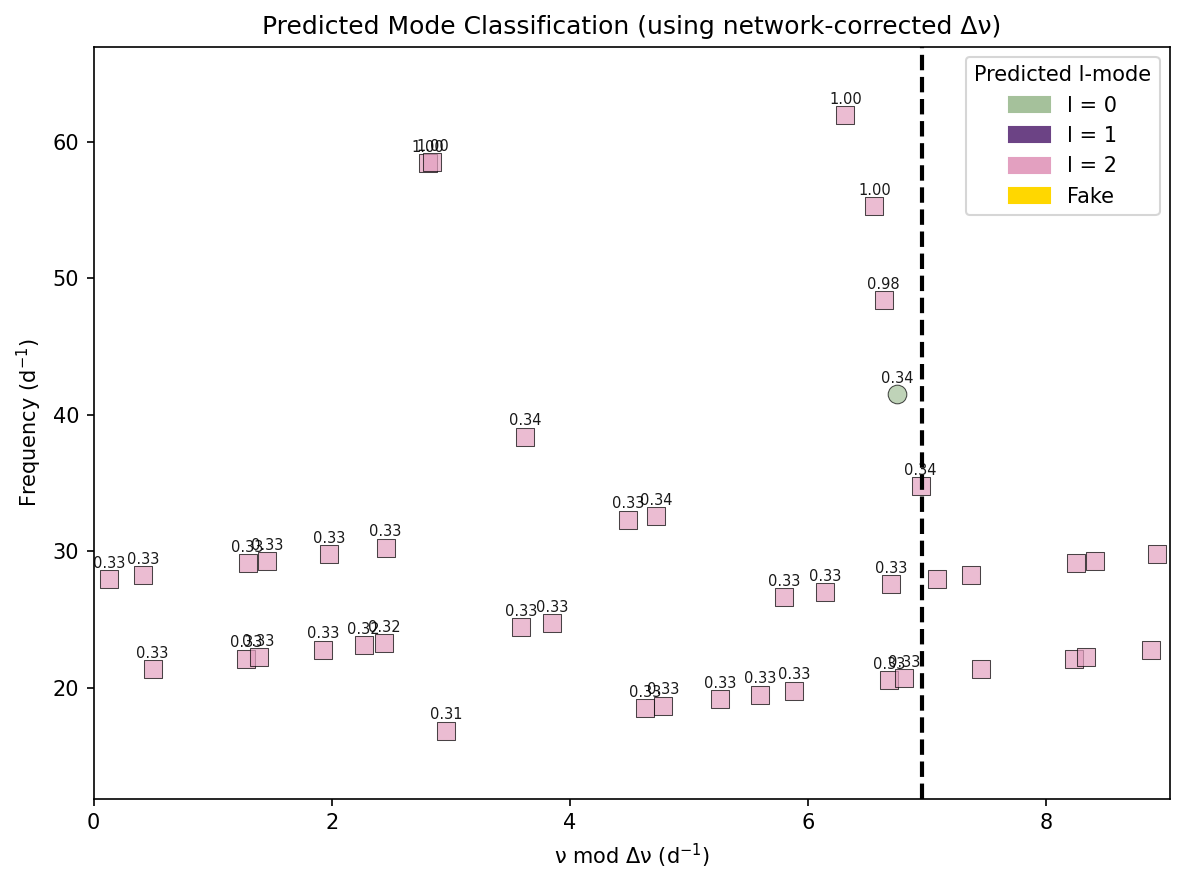

In [8]:
# inference_with_dnu_correction.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# ---------------------------
# Replace or reuse these:
checkpoint_path = "segmentation_pointnet_dsfmeanpdnu.pth"  # trained checkpoint
# frequencies for the single star (your example)
frequencies = np.array([
    21.36513, 27.95328, 34.77609, 41.53747, 48.37933, 55.25743, 61.97086,
    16.87165, 32.55347, 38.40601, 58.46084, 28.24243, 27.01307, 20.59936,
    18.54655, 18.69868, 19.17648, 19.50970, 19.80056, 20.72404, 22.15081,
    22.25558, 22.79990, 23.13894, 23.30843, 24.46210, 24.72073, 26.67124,
    27.57177, 29.12013, 29.28361, 29.80605, 30.27912, 32.31897, 58.50036
], dtype=float)

# your baseline delta_nu for this star (d^-1)
user_delta_nu = 6.83

# ---------------------------
# Model code (must match training definitions)
FAKE_CLASS = 3
DROPPED_CLASS = -1

class DeltaNuCorrection(nn.Module):
    def __init__(self, n_stars, delta_nu_hard):
        super().__init__()
        # register_buffer keeps it as a buffer (not a parameter)
        self.register_buffer("delta_nu_hard", delta_nu_hard.clone())
        # trainable per-star correction
        self.delta_nu_corr = nn.Parameter(torch.zeros_like(delta_nu_hard))
        self.eps = 1e-3

    def forward(self, frequencies, star_indices):
        # frequencies: [B, N] with B = batch (stars), N = num points per star
        delta = (self.delta_nu_hard[star_indices] + self.delta_nu_corr[star_indices]).clamp_min(self.eps)
        delta = delta.unsqueeze(1)  # [B, 1]
        mod_freq = frequencies % delta
        return mod_freq

class PointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, aggregator="mean"):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        # note: padding chosen to match training; if your checkpoint was trained
        # with different padding change these to match.
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=1)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)
        self.aggregator = aggregator

    def forward(self, x, mask=None):
        B, N, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)  # [B, 1, N]
        x_modnu = x[:, :, 1].unsqueeze(1)  # [B, 1, N]
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))
        if self.aggregator == "max":
            if mask is not None:
                m = (mask.unsqueeze(1) > 0).float()
                x = x.masked_fill(m == 0, -1e9)
            x = x.amax(dim=-1, keepdim=True)  # global max
        elif self.aggregator == "mean":
            if mask is None:
                x = x.mean(dim=-1, keepdim=True)
            else:
                m = (mask.unsqueeze(1) > 0).float()
                x = (x * m).sum(dim=-1, keepdim=True) / m.sum(dim=-1, keepdim=True).clamp_min(1.0)
        else:
            raise ValueError(f"Unknown aggregator: {self.aggregator}")
        return x.view(B, -1)

class SegmentationPointNet(nn.Module):
    def __init__(self, n_stars, delta_nu_hard, num_classes=4, point_dimension=2, aggregator="mean"):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension, aggregator=aggregator)
        nhidden = 64
        nfeat = 64
        self.fc_1 = nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = nn.Linear(nhidden, num_classes)
        self.delta_nu_module = DeltaNuCorrection(n_stars, delta_nu_hard)

    def forward(self, x, star_indices, mask=None):
        # x: [B, N, 2] (freq, placeholder_mod)
        freq = x[:, :, 0]                       # [B, N]
        modf = self.delta_nu_module(freq, star_indices)  # recomputed inside
        x2 = torch.stack((freq, modf), dim=2)  # [B, N, 2]
        g = self.base_pointnet(x2, mask=mask)  # [B, nfeat]
        g = g.unsqueeze(1).expand(-1, x2.shape[1], -1)  # [B, N, nfeat]
        z = torch.cat([x2, g], dim=2)  # [B, N, nfeat+2]
        z = F.relu(self.fc_1(z))
        return F.log_softmax(self.fc_2(z), dim=2)

state = torch.load(checkpoint_path, map_location="cpu")

# If the checkpoint was saved as state_dict directly, state is a dict of param tensors.
# Find the key for delta_nu_module.delta_nu_hard (exact name used in training).
# If it's nested under another top-level dict (e.g. {"model_state": ...}) try to detect that.
if "state_dict" in state and isinstance(state["state_dict"], dict):
    state_dict = state["state_dict"]
else:
    state_dict = state

# Attempt to locate the buffer key
possible_keys = [k for k in state_dict.keys() if "delta_nu_module.delta_nu_hard" in k]
if len(possible_keys) == 0:
    # try plain key name
    if "delta_nu_module.delta_nu_hard" in state_dict:
        possible_keys = ["delta_nu_module.delta_nu_hard"]

if len(possible_keys) == 0:
    raise KeyError("Could not find 'delta_nu_module.delta_nu_hard' in the checkpoint keys. "
                   "Available keys: " + ", ".join(list(state_dict.keys())[:20]))

key = possible_keys[0]
saved_delta = state_dict[key]  # torch tensor
if not isinstance(saved_delta, torch.Tensor):
    saved_delta = torch.tensor(saved_delta)

n_stars_saved = saved_delta.numel()
print(f"Checkpoint delta_nu_hard length = {n_stars_saved}")

# Build model with the same number of stars (so loading is consistent)
model = SegmentationPointNet(n_stars=n_stars_saved, delta_nu_hard=saved_delta.clone(), num_classes=4, point_dimension=2, aggregator="mean")

# Load state_dict into model; try strict load first, fallback to non-strict with warning
try:
    model.load_state_dict(state_dict)
except RuntimeError as e:
    print("Strict load failed, trying non-strict load (some keys may not match exactly):")
    model.load_state_dict(state_dict, strict=False)

model.eval()

# For inference on a new single star:
# We will overwrite the first stored delta_nu_hard value to be the user baseline delta_nu,
# and use star index 0 for the single-star batch.
with torch.no_grad():
    # overwrite baseline for index 0
    new_dnu_hard = model.delta_nu_module.delta_nu_hard.clone()
    new_dnu_hard[0] = torch.tensor(user_delta_nu, dtype=new_dnu_hard.dtype)
    # assign back (buffer)
    model.delta_nu_module.delta_nu_hard = new_dnu_hard

    # Prepare input tensor: shape [B=1, N, 2]
    N = frequencies.shape[0]
    # second column is ignored by forward (mod is recomputed), but supply placeholder zeros
    X_in = np.stack([frequencies, np.zeros_like(frequencies)], axis=1).astype(np.float32)
    X_tensor = torch.tensor(X_in).unsqueeze(0)  # [1, N, 2]

    star_indices = torch.tensor([0], dtype=torch.long)  # use first slot in delta arrays

    # Run model
    logits = model(X_tensor, star_indices=star_indices)   # [1, N, num_classes]
    probs = torch.exp(logits)[0].cpu().numpy()          # [N, C]
    preds = probs.argmax(axis=1)

    # Extract the learned delta_nu correction for this star (index 0)
    delta_corr = model.delta_nu_module.delta_nu_corr.detach().cpu().numpy()[0].item()
    delta_hard_used = model.delta_nu_module.delta_nu_hard.detach().cpu().numpy()[0].item()
    delta_corrected = delta_hard_used + delta_corr

    print(f"Baseline Δν used (index 0): {delta_hard_used:.6f}")
    print(f"Learned Δν correction (delta_nu_corr[0]): {delta_corr:.6f}")
    print(f"Corrected Δν (baseline + corr): {delta_corrected:.6f}")

color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
marker_map = {0: "o", 1: "D", 2: "s", 3: "*"}
legend_elements = [
    mpatches.Patch(color=color_map[0], label="l = 0"),
    mpatches.Patch(color=color_map[1], label="l = 1"),
    mpatches.Patch(color=color_map[2], label="l = 2"),
    mpatches.Patch(color=color_map[3], label="Fake"),
]

nu_mod_network = np.mod(frequencies, delta_corrected)

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

for i, (f, nu_mod, p, pr) in enumerate(zip(frequencies, nu_mod_network, preds, probs)):
    marker = marker_map[int(p)]
    color = color_map[int(p)]
    conf = pr[int(p)]  # probability of predicted class
    # scatter both original and shifted points
    ax.scatter(nu_mod, f, c=color, marker=marker, edgecolors="black",
               linewidths=0.5, s=80, alpha=0.7)
    ax.scatter(nu_mod + delta_corrected, f, c=color, marker=marker,
               edgecolors="black", linewidths=0.5, s=80, alpha=0.7)
    # add text with probability
    ax.text(nu_mod, f + 0.6, f"{conf:.2f}", ha="center", va="bottom",
            fontsize=7, rotation=0, alpha=0.9)

ax.axvline(delta_corrected, color="black", linestyle="--", linewidth=2)
ax.set_xlim(0, delta_corrected * 1.3)
ax.set_ylim(max(0, frequencies.min()-5), frequencies.max()+5)
ax.legend(handles=legend_elements, title="Predicted l-mode", loc="upper right")
ax.set_title("Predicted Mode Classification (using network-corrected Δν)", fontsize=12)
ax.set_xlabel("ν mod Δν (d$^{-1}$)")
ax.set_ylabel("Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

# HD 261711 
https://ui.adsabs.harvard.edu/abs/2013A%26A...552A..68Z/abstract

Checkpoint delta_nu_hard length = 122651
Baseline Δν used (index 0): 6.830000
Learned Δν correction (delta_nu_corr[0]): 0.126755
Corrected Δν (baseline + corr): 6.956755


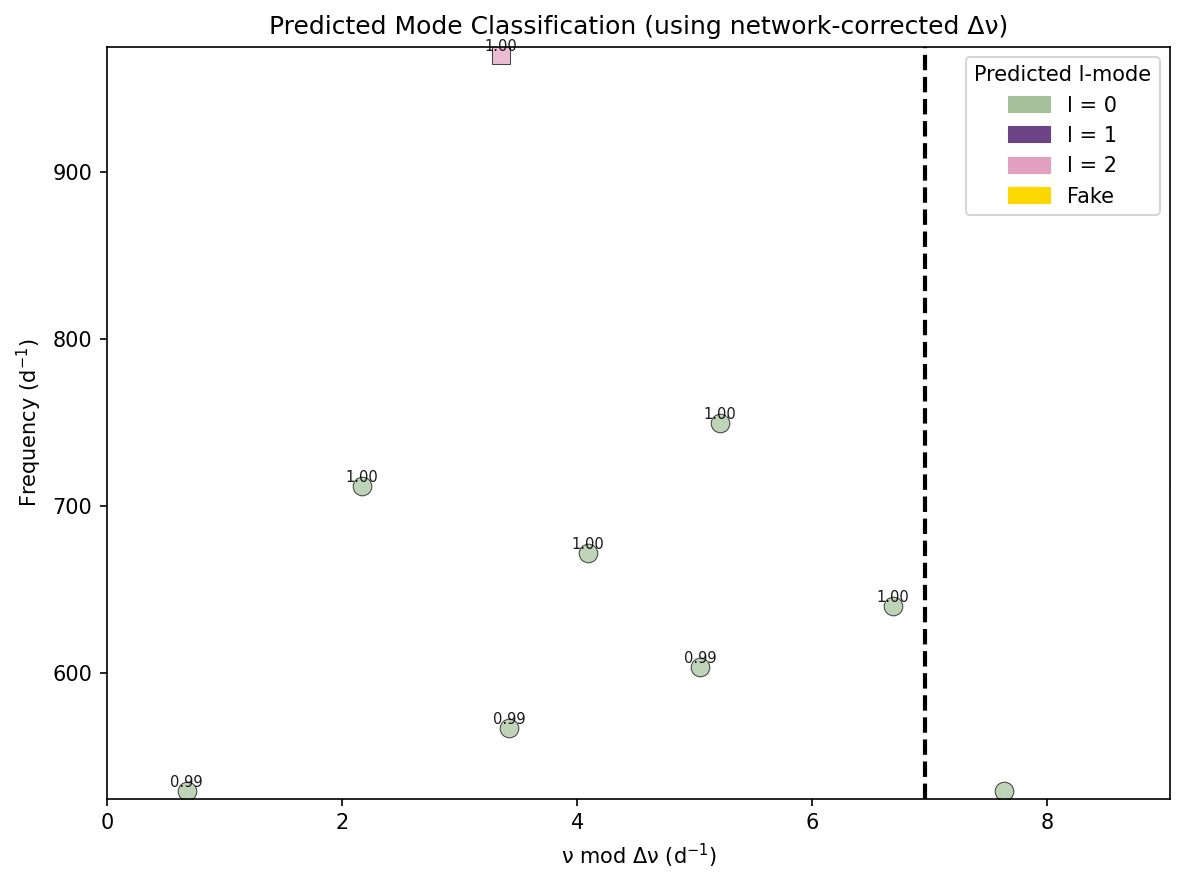

In [10]:
# inference_with_dnu_correction.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

checkpoint_path = "segmentation_pointnet_dsfmeanpdnu.pth"  # trained checkpoint
'''
frequencies = 11.574074*np.array([
    61.4976, 58.0272,61.4401,58.5821,58.0553,55.4566,55.0608,58.429,48.982,55.366,51.217,54.742,53.131,61.281,52.057,52.374,55.891,58.231,
    54.808,45.739,61.463,64.764,83.84,61.34,57.971
])
'''
# now only weighted frequencies used 
frequencies = np.array([529.39,566.92,603.33,639.75,671.94,711.76,749.59,970.34])

delta_nu = 38.9 # µHz
FAKE_CLASS = 3
DROPPED_CLASS = -1

class DeltaNuCorrection(nn.Module):
    def __init__(self, n_stars, delta_nu_hard):
        super().__init__()
        self.register_buffer("delta_nu_hard", delta_nu_hard.clone())
        self.delta_nu_corr = nn.Parameter(torch.zeros_like(delta_nu_hard))
        self.eps = 1e-3

    def forward(self, frequencies, star_indices):
        delta = (self.delta_nu_hard[star_indices] + self.delta_nu_corr[star_indices]).clamp_min(self.eps)
        delta = delta.unsqueeze(1)  # [B, 1]
        mod_freq = frequencies % delta
        return mod_freq

class PointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2, aggregator="mean"):
        super(PointNet, self).__init__()
        a = 3
        nfeat = 64
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=1)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=1)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)
        self.aggregator = aggregator

    def forward(self, x, mask=None):
        B, N, _ = x.shape
        x_freq = x[:, :, 0].unsqueeze(1)  # [B, 1, N]
        x_modnu = x[:, :, 1].unsqueeze(1)  # [B, 1, N]
        x = self.conv_1_a(x_freq) + self.conv_1_b(x_modnu)
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))
        if self.aggregator == "max":
            if mask is not None:
                m = (mask.unsqueeze(1) > 0).float()
                x = x.masked_fill(m == 0, -1e9)
            x = x.amax(dim=-1, keepdim=True)  # global max
        elif self.aggregator == "mean":
            if mask is None:
                x = x.mean(dim=-1, keepdim=True)
            else:
                m = (mask.unsqueeze(1) > 0).float()
                x = (x * m).sum(dim=-1, keepdim=True) / m.sum(dim=-1, keepdim=True).clamp_min(1.0)
        else:
            raise ValueError(f"Unknown aggregator: {self.aggregator}")
        return x.view(B, -1)

class SegmentationPointNet(nn.Module):
    def __init__(self, n_stars, delta_nu_hard, num_classes=4, point_dimension=2, aggregator="mean"):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension, aggregator=aggregator)
        nhidden = 64
        nfeat = 64
        self.fc_1 = nn.Linear(nfeat + 2, nhidden)
        self.fc_2 = nn.Linear(nhidden, num_classes)
        self.delta_nu_module = DeltaNuCorrection(n_stars, delta_nu_hard)

    def forward(self, x, star_indices, mask=None):
        freq = x[:, :, 0]                       # [B, N]
        modf = self.delta_nu_module(freq, star_indices)  # recomputed inside
        x2 = torch.stack((freq, modf), dim=2)  # [B, N, 2]
        g = self.base_pointnet(x2, mask=mask)  # [B, nfeat]
        g = g.unsqueeze(1).expand(-1, x2.shape[1], -1)  # [B, N, nfeat]
        z = torch.cat([x2, g], dim=2)  # [B, N, nfeat+2]
        z = F.relu(self.fc_1(z))
        return F.log_softmax(self.fc_2(z), dim=2)

state = torch.load(checkpoint_path, map_location="cpu")

# If the checkpoint was saved as state_dict directly, state is a dict of param tensors.
# Find the key for delta_nu_module.delta_nu_hard (exact name used in training).
# If it's nested under another top-level dict (e.g. {"model_state": ...}) try to detect that.
if "state_dict" in state and isinstance(state["state_dict"], dict):
    state_dict = state["state_dict"]
else:
    state_dict = state

# Attempt to locate the buffer key
possible_keys = [k for k in state_dict.keys() if "delta_nu_module.delta_nu_hard" in k]
if len(possible_keys) == 0:
    # try plain key name
    if "delta_nu_module.delta_nu_hard" in state_dict:
        possible_keys = ["delta_nu_module.delta_nu_hard"]

if len(possible_keys) == 0:
    raise KeyError("Could not find 'delta_nu_module.delta_nu_hard' in the checkpoint keys. "
                   "Available keys: " + ", ".join(list(state_dict.keys())[:20]))

key = possible_keys[0]
saved_delta = state_dict[key]  # torch tensor
if not isinstance(saved_delta, torch.Tensor):
    saved_delta = torch.tensor(saved_delta)

n_stars_saved = saved_delta.numel()
print(f"Checkpoint delta_nu_hard length = {n_stars_saved}")

# Build model with the same number of stars (so loading is consistent)
model = SegmentationPointNet(n_stars=n_stars_saved, delta_nu_hard=saved_delta.clone(), num_classes=4, point_dimension=2, aggregator="mean")

# Load state_dict into model; try strict load first, fallback to non-strict with warning
try:
    model.load_state_dict(state_dict)
except RuntimeError as e:
    print("Strict load failed, trying non-strict load (some keys may not match exactly):")
    model.load_state_dict(state_dict, strict=False)

model.eval()

with torch.no_grad():
    new_dnu_hard = model.delta_nu_module.delta_nu_hard.clone()
    new_dnu_hard[0] = torch.tensor(user_delta_nu, dtype=new_dnu_hard.dtype)
    model.delta_nu_module.delta_nu_hard = new_dnu_hard

    # Prepare input tensor: shape [B=1, N, 2]
    N = frequencies.shape[0]
    # second column is ignored by forward (mod is recomputed), but supply placeholder zeros
    X_in = np.stack([frequencies, np.zeros_like(frequencies)], axis=1).astype(np.float32)
    X_tensor = torch.tensor(X_in).unsqueeze(0)  # [1, N, 2]

    star_indices = torch.tensor([0], dtype=torch.long)  # use first slot in delta arrays

    # Run model
    logits = model(X_tensor, star_indices=star_indices)   # [1, N, num_classes]
    probs = torch.exp(logits)[0].cpu().numpy()          # [N, C]
    preds = probs.argmax(axis=1)

    # Extract the learned delta_nu correction for this star (index 0)
    delta_corr = model.delta_nu_module.delta_nu_corr.detach().cpu().numpy()[0].item()
    delta_hard_used = model.delta_nu_module.delta_nu_hard.detach().cpu().numpy()[0].item()
    delta_corrected = delta_hard_used + delta_corr

    print(f"Baseline Δν used (index 0): {delta_hard_used:.6f}")
    print(f"Learned Δν correction (delta_nu_corr[0]): {delta_corr:.6f}")
    print(f"Corrected Δν (baseline + corr): {delta_corrected:.6f}")

color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', 3: 'gold'}
marker_map = {0: "o", 1: "D", 2: "s", 3: "*"}
legend_elements = [
    mpatches.Patch(color=color_map[0], label="l = 0"),
    mpatches.Patch(color=color_map[1], label="l = 1"),
    mpatches.Patch(color=color_map[2], label="l = 2"),
    mpatches.Patch(color=color_map[3], label="Fake"),
]

nu_mod_network = np.mod(frequencies, delta_corrected)

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

for i, (f, nu_mod, p, pr) in enumerate(zip(frequencies, nu_mod_network, preds, probs)):
    marker = marker_map[int(p)]
    color = color_map[int(p)]
    conf = pr[int(p)]  # probability of predicted class
    # scatter both original and shifted points
    ax.scatter(nu_mod, f, c=color, marker=marker, edgecolors="black",
               linewidths=0.5, s=80, alpha=0.7)
    ax.scatter(nu_mod + delta_corrected, f, c=color, marker=marker,
               edgecolors="black", linewidths=0.5, s=80, alpha=0.7)
    # add text with probability
    ax.text(nu_mod, f + 0.6, f"{conf:.2f}", ha="center", va="bottom",
            fontsize=7, rotation=0, alpha=0.9)

ax.axvline(delta_corrected, color="black", linestyle="--", linewidth=2)
ax.set_xlim(0, delta_corrected * 1.3)
ax.set_ylim(max(0, frequencies.min()-5), frequencies.max()+5)
ax.legend(handles=legend_elements, title="Predicted l-mode", loc="upper right")
ax.set_title("Predicted Mode Classification (using network-corrected Δν)", fontsize=12)
ax.set_xlabel("ν mod Δν (d$^{-1}$)")
ax.set_ylabel("Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

## Confusion matrix

Original shapes: (15332, 30) (15332, 30)


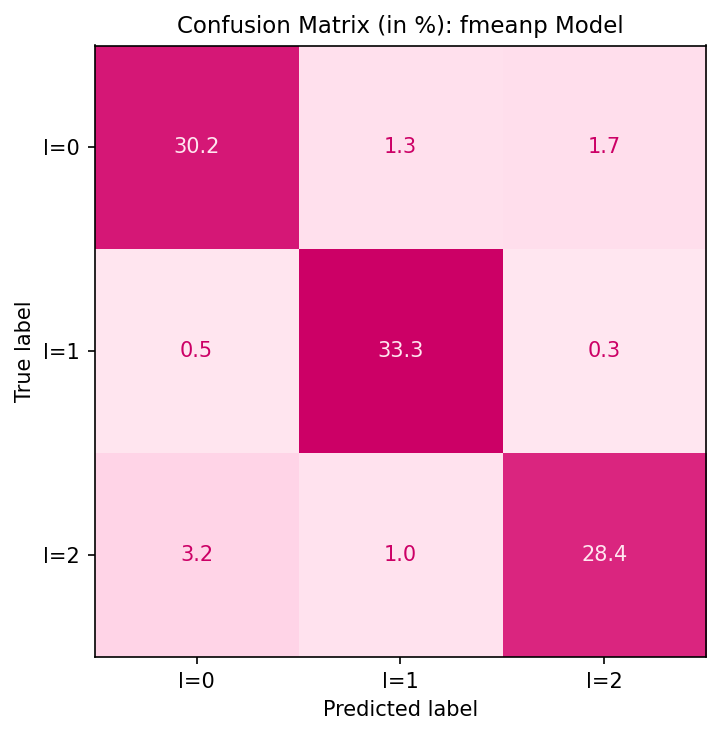

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load files
with open("test_predictions_fmeanp.pkl", "rb") as f:
    log_preds = pickle.load(f)   # likely [B, N, C]
with open("test_targets_fmeanp.pkl", "rb") as f:
    true_labels = pickle.load(f) # likely [B, N]

print("Original shapes:", log_preds.shape, true_labels.shape)

probs = np.exp(log_preds)
pred_labels = log_preds.astype(int) 
true_flat = true_labels.flatten()
pred_flat = pred_labels.flatten()

cm = confusion_matrix(true_flat, pred_flat, labels=[0, 1, 2])
cm_percent = cm / cm.sum() * 100

pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["#ffe6f0", "#ff80bf", "#cc0066"])

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["l=0", "l=1", "l=2"])
disp.plot(ax=ax, cmap=pink_cmap, colorbar=False, values_format=".1f")

plt.title("Confusion Matrix (in %): fmeanp Model", fontsize=11)
plt.savefig("confusionmatrix_fmeanp.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True, dpi=300)
plt.tight_layout()
plt.show()

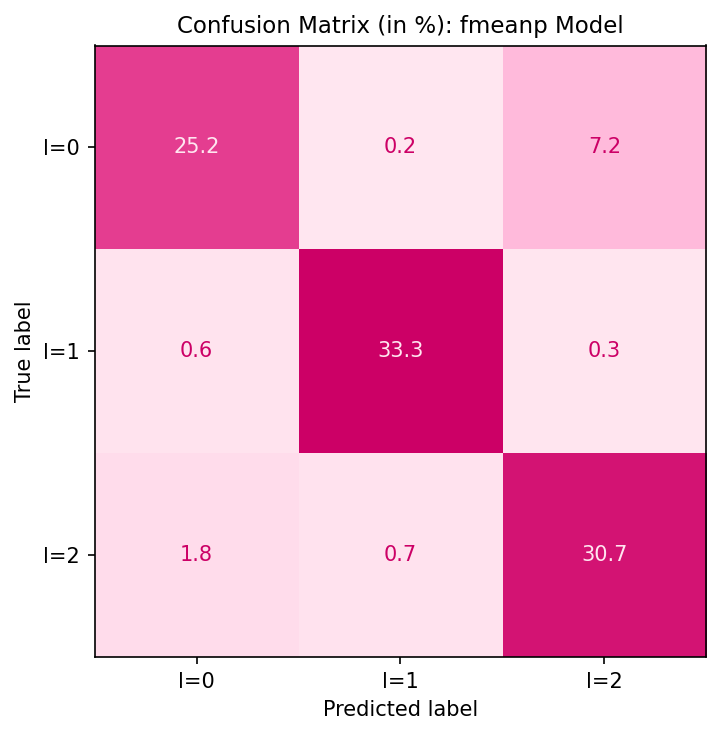

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open("test_predictions_dsfmeanp.pkl", "rb") as f:
    log_preds = pickle.load(f)   # likely [B, N, C]
with open("test_targets_dsfmeanp.pkl", "rb") as f:
    true_labels = pickle.load(f) # likely [B, N]

# print("Original shapes:", log_preds.shape, true_labels.shape)
probs = np.exp(log_preds)
pred_labels = log_preds.astype(int) 
true_flat = true_labels.flatten()
pred_flat = pred_labels.flatten()

cm = confusion_matrix(true_flat, pred_flat, labels=[0, 1, 2])
cm_percent = cm / cm.sum() * 100

pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["#ffe6f0", "#ff80bf", "#cc0066"])

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["l=0", "l=1", "l=2"])
disp.plot(ax=ax, cmap=pink_cmap, colorbar=False, values_format=".1f")

plt.title("Confusion Matrix (in %): fmeanp Model", fontsize=11)
plt.savefig("confusionmatrix_dsfmeanp.jpg", bbox_inches="tight", pad_inches=0.3, transparent=True, dpi=300)
plt.tight_layout()
plt.show()